In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error
import warnings
import random
warnings.filterwarnings("ignore")
import os
from IPython.display import Image
import matplotlib.pyplot as plt
os.environ['KAGGLE_CONFIG_DIR']='/home/jupyter/case_study'

In [2]:
data=pd.read_pickle('formated_data.pkl')
data = data[data['day']>1500]
rolling = ['rolling_median_7','rolling_median_14','rolling_median_28']
data = data.drop(rolling,axis=1)
train = data[data['day']<=1913]
test = data[(data['day']>=1914) & (data['day']<=1941)]

In [3]:
xtest = test.drop('sales',axis=1)
ytest = test['sales']

In [4]:
#Splitting the train data equally.
D1,D2=train_test_split(train,test_size=0.5,random_state=42)
D1_x = D1.drop('sales',axis=1)
D1_y = D1['sales']
D2_x = D2.drop('sales',axis=1)
D2_y = D2['sales']

In [33]:
def k_samples(x,y,k,n=500000):
    '''
    This function is used to create k samples from the data(x,y) with size n.
    
    Parameters:
    1.x(dataframe) : data with input features.
    2.y(dataframe) : data with target features.
    3.k(int) : number of base learners.
    3.n(int) : Number of rows in each sample, by default 500000 is set.
    
    Returns:
    List of x and y samples.
    '''
    x_samples,y_samples=[],[]
    for i in range(k):
        #to get random indeces from index 0 to last index of length 'n'. 
        indices=np.random.randint(0,x.shape[0],n)
        #getting x and y values of the randomly selected index.
        x_sample=x.iloc[indices]
        y_sample=y.iloc[indices]
        #appending the generated samples to a list.
        x_samples.append(x_sample)
        y_samples.append(y_sample)
    return x_samples,y_samples

In [34]:
print(k_samples.__doc__)


    This function is used to create k samples from the data(x,y) with size n.
    
    Parameters:
    1.x(dataframe) : data with input features.
    2.y(dataframe) : data with target features.
    3.k(int) : number of base learners.
    3.n(int) : Number of rows in each sample, by default 500000 is set.
    
    Returns:
    List of x and y samples.
    


In [29]:
def base_models1(x_samples, y_samples):
    '''
    This function is used to train base models.
    
    Parameters:
    x_samples(list): list of x samples(samples with input features)
    y_samples(list): list of y samples(samples with target features)
    
    Returns:
    List of trained base models
    '''
    trained_base_models = []
    for i in range(len(x_samples)):
        m = np.random.randint(0,5)
        if m == 0:
            #Training Bayesian Ridge regression model
            base_model = linear_model.BayesianRidge()
            base_model.fit(x_samples[i],y_samples[i])
            trained_base_models.append(base_model)
        elif m == 1:
            #Training Ridge regression model
            base_model = linear_model.Ridge()
            base_model.fit(x_samples[i], y_samples[i])
            trained_base_models.append(base_model)
        elif m ==2:
            #Training Decision Tree Regressor model
            base_model =  tree.DecisionTreeRegressor()
            base_model.fit(x_samples[i], y_samples[i])
            trained_base_models.append(base_model)
        elif m ==3:
            #Training Bayesian LightGBM Regressor model
            base_model =  LGBMRegressor()
            base_model.fit(x_samples[i], y_samples[i])
            trained_base_models.append(base_model)
        elif m ==4:
            #Training CatBoost Regressor model
            base_model =  CatBoostRegressor(logging_level="Silent")
            base_model.fit(x_samples[i], y_samples[i])
            trained_base_models.append(base_model)
    return trained_base_models

In [30]:
print(base_models1.__doc__)


    This function is used to train base models.
    
    Parameters:
    x_samples(list): list of x samples(samples with input features)
    y_samples(list): list of y samples(samples with target features)
    
    Returns:
    List of trained base models
    


In [35]:
def base_model_prediction(base_models, D2_x):
    '''
    This function is used to get predictions out of base models to feed it as input to meta model.
    
    Parameters:
    base_models(list): Trained base models
    D2_x(dataframe) : input data to get predictions from base models
    
    Returns:
    Dataframe with k predictions(k is the number of base learners)
    '''
    base_predictions = {}
    for i in range(len(base_models)):
        cname = 'M' + str(i)
        prediction = base_models[i].predict(D2_x)
        base_predictions[cname] = prediction
    return pd.DataFrame(base_predictions)

In [36]:
print(base_model_prediction.__doc__)


    This function is used to get predictions out of base models to feed it as input to meta model.
    
    Parameters:
    base_models(list): Trained base models
    D2_x(dataframe) : input data to get predictions from base models
    
    Returns:
    Dataframe with k predictions(k is the number of base learners)
    


In [9]:
number = [5,10,15,20,30,40,50]
rmse_list = []
for n in tqdm(number):
    a,b = k_samples(D1_x, D1_y, n)
    base_models = base_models1(a,b)
    base_models_predictions_df = base_model_prediction(base_models, D2_x)
    #Using Linear regression as the meta model.
    meta_model = linear_model.LinearRegression()
    meta_model.fit(base_models_predictions_df, D2_y)

    base_test_predictions_df = base_model_prediction(base_models, xtest)
    ytest_pred = meta_model.predict(base_test_predictions_df)
    rmse = mse(ytest, ytest_pred)
    rmse_list.append(rmse)

100%|██████████| 7/7 [14:28<00:00, 124.04s/it]


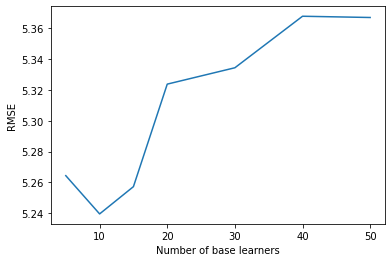

In [10]:
plt.plot(number, rmse_list)
plt.xlabel('Number of base learners')
plt.ylabel('RMSE')
plt.show()

### Optimal base learners are <b>around 10</b> , but we dont know the exact number of optimal base learners .So again <b>finding optimal base learners between 6 and 14</b>.

In [11]:
number=np.arange(6,14)
mse_list = []
for n in tqdm(number):
    a,b = k_samples(D1_x, D1_y, n)
    base_models = base_models1(a,b)
    base_models_predictions_df = base_model_prediction(base_models, D2_x)

    meta_model = linear_model.LinearRegression()
    meta_model.fit(base_models_predictions_df, D2_y)

    base_test_predictions_df = base_model_prediction(base_models, xtest)
    ytest_pred = meta_model.predict(base_test_predictions_df)
    mse = mean_squared_error(ytest, ytest_pred)
    mse_list.append(mse)

100%|██████████| 8/8 [15:04<00:00, 113.03s/it]


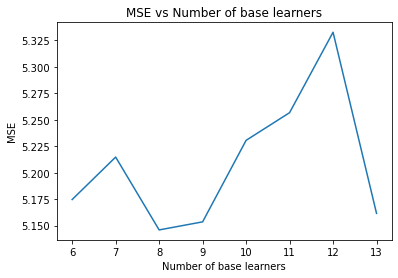

In [18]:
plt.plot(number, mse_list)
plt.xlabel('Number of base learners')
plt.ylabel('MSE')
plt.title('MSE vs Number of base learners')
plt.show()

## <b>Optimal number of base learner is 8</b>. 

In [17]:
n=8
a,b = k_samples(D1_x, D1_y, n)
base_models = base_models1(a,b)
base_models_predictions_df = base_model_prediction(base_models, D2_x)

meta_model = linear_model.LinearRegression()
meta_model.fit(base_models_predictions_df, D2_y)

base_test_predictions_df = base_model_prediction(base_models, xtest)
ytest_pred = meta_model.predict(base_test_predictions_df)
mse1 = mean_squared_error(ytest, ytest_pred)
print("MSE for stacking regression model with 8 base models is",mse1)
val_pred = np.reshape(ytest_pred, (-1, 28),order = 'F')

MSE for stacking regression model with 8 base models is 5.180074258690378


In [15]:
#Predicting output for unseen(evaluation data of sales_train.csv) data using stacking regression model.
file_name = "stacked_regressor1.csv"
test1 = data[(data['day']>=1942)]
test1_x = test1.drop('sales',axis=1)
test1_y = test1.sales

base_test_predictions_df = base_model_prediction(base_models, test1_x)
ytest_pred = meta_model.predict(base_test_predictions_df)
test_pred = np.reshape(ytest_pred, (-1, 28),order = 'F')
    
submission = pd.read_csv("sample_submission.csv")
sub_validation = submission.iloc[:30490,:]
sub_evaluation = submission.iloc[30490:,:]

F_columns = submission.columns[1:]
for i in tqdm(range(len(F_columns))):
    sub_validation[F_columns[i]] = val_pred[:,i]
    sub_evaluation[F_columns[i]] = test_pred[:,i]

submission = pd.concat([sub_validation,sub_evaluation])
submission.to_csv(file_name,index = False)
print("Submission file with name "+file_name+" created successfully")

100%|██████████| 28/28 [00:00<00:00, 522.45it/s]


Submission file with name stacked_regressor1.csv created successfully


In [16]:
!kaggle competitions submit -c m5-forecasting-accuracy -f stacked_regressor1.csv -m "stacking regression model"

100%|██████████████████████████████████████| 32.7M/32.7M [00:00<00:00, 49.8MB/s]
Successfully submitted to M5 Forecasting - Accuracy

## Kaggle Submission result

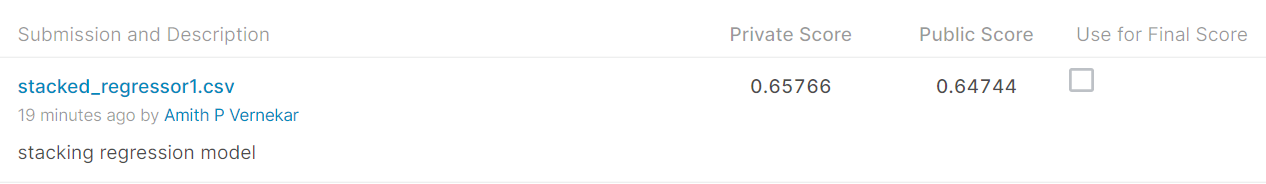

In [2]:
Image(filename="stack1.png")

## Results from basic models  (Submitted as first cut models)

||Model name|Private Score| Public Score
|--|--|--|--|
|1|Linear Regression|0.71721|0.71875|
|2|Ridge Regression|0.71707|0.7196|
|3|Lasso Regression|0.84179|0.86308|
|4|Bayesian Ridge Regression|0.71734|0.71889|
|5|ElasticNet|0.72513|0.72270|
|6|Least Angle Regression|0.76252|0.78267|

## Result from Stacked Regression Model
 * Base Models : Bayesian Ridge , Ridge , Decision Tree, Light GBM , Cat Boost Regression model.
 * Meta Model : Linear Regression.

||Model name|Private Score| Public Score
|--|--|--|--|
||<b>Stacked Regression Model</b>|<b>0.65766</b>|<b>0.64744</b>|

* Stacked regression model performed well when compared to basic models.
* Private score of 0.65766 put me in <b>top 5-6%</b> in the leaderboard.
